This notebook uses the Scientific Python (scipy) stack tools to generate flow duration curves from current USGS NWIS data.

Using recipes from this notebook, you can make:
* USGS Station Summaries
* Flow duration curves
* Iterative import and compilation of USGS station information and data
* boxplots using pandas
* iterative charts (one monthly summary boxplot per station)
* Gantt charts of USGS stations

## Background

Check out this for some great `pandas` applications:
http://earthpy.org/time_series_analysis_with_pandas_part_2.html

In [1]:
%matplotlib inline
import pandas as pd
import platform
import sys
#import xmltodict
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(matplotlib.__version__))

Operating System Linux 3.19.0-43-generic
Python Version 2.7.6 (default, Jun 22 2015, 17:58:13) 
[GCC 4.8.2]
Pandas Version 0.17.1
Numpy Version 1.10.4
Matplotlib Version 1.5.1


This following the suggested import call for the well application function.

In [3]:
import wellapplication as wa

In [4]:
wa.__version__

'0.2.1'

Select a HUC (Hydrologic Unit Code) or HUCs to process.  The USGS queries use HUC 8.  To select a HUC 8, you can refer to the <a href=http://viewer.nationalmap.gov/viewer/nhd.html?p=nhd>National Map</a>.

In [11]:
HUClist = [16020301]

Call function class usgs and assign it as USGS.  This will allow for the implementation of all of the usgs functions.  This function class allows for the import of USGS data.

In [12]:
USGS = wa.usgs()

Import list of stations based on Cache Valley HUCS. The function `getStationsfromHUC` will import a list of stations from a list of HUCs.

In [13]:
stations = USGS.getStationsfromHUC(HUClist)

Import site data from HUCS. The function `getStationsInfoFromHUC` will import a list of stations information from a list of HUCs and save it in a Pandas DataFrame.

In [14]:
siteinfo = USGS.getStationInfoFromHUC(HUClist)

Inspect columns of imported site data

In [15]:
siteinfo.columns

Index([u'agency_cd', u'site_no', u'station_nm', u'site_tp_cd', u'dec_lat_va',
       u'dec_long_va', u'coord_acy_cd', u'dec_coord_datum_cd', u'alt_va',
       u'alt_acy_va', u'alt_datum_cd', u'huc_cd'],
      dtype='object')

Reproject Lat Long into UTM X and Y.  These functions use an import from the `pyproj` package.

In [16]:
siteinfo['UTM_X'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: wa.avgMeths.projx(x),1)
siteinfo['UTM_Y']= siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: wa.avgMeths.projy(x),1)

Use the `getelev` function to call the point elevation service of the USGS. The Elevation Point Query Service <a href=http://ned.usgs.gov/epqs/> EPQS </a>

In [17]:
siteinfo['Elev'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: USGS.getelev(x),1)

The `getWLfromHUC` function downloads all of the data for a huc from the <a href=http://waterservices.usgs.gov/rest/GW-Levels-Test-Tool.html> USGS Groundwater Service Tool</a> and outputs it into a Pandas DataFrame.

In [18]:
data = USGS.getWLfromHUC(HUClist)

The `cleanGWL` function does a simple query on the USGS Water Level DataFrame to remove all of the <a href=http://help.waterdata.usgs.gov/codes-and-parameters/water-level-site-status-codes-lev_status_cd> lev_status_cd</a> value codes that signify error.

In [19]:
data = USGS.cleanGWL(data)

In [20]:
stationWL = pd.merge(data, siteinfo, on='site_no', how='left')

In [21]:
stationWL['wlelev'] = stationWL[['lev_va','Elev']].apply(lambda x: wa.avgMeths.getwlelev(x),1)

In [22]:
stationWL['date'], stationWL['Year'], stationWL['Month'] = zip(*stationWL['lev_dt'].apply(lambda x: wa.avgMeths.getyrmnth(x),1))

The HUCdf function can produce an average monthly changes over time

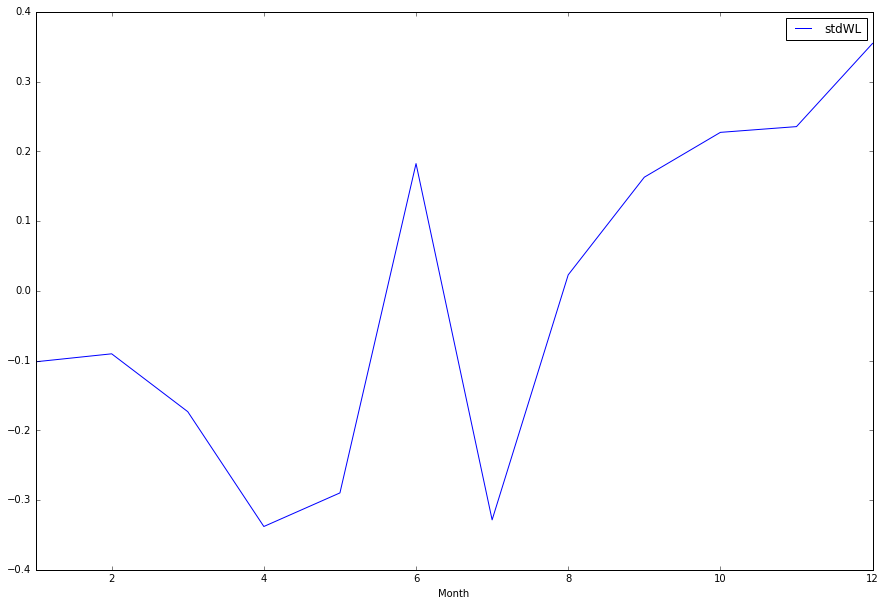

In [23]:
df1, df2 = USGS.HUCdf(HUClist)

The HUCplot function will produce two charts showing the HUC-wide groundwater level trends over time.

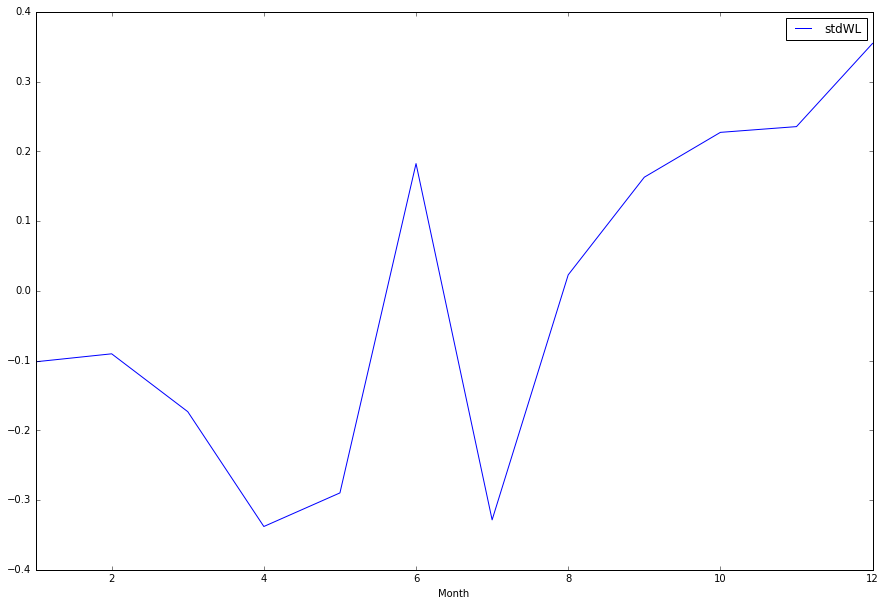

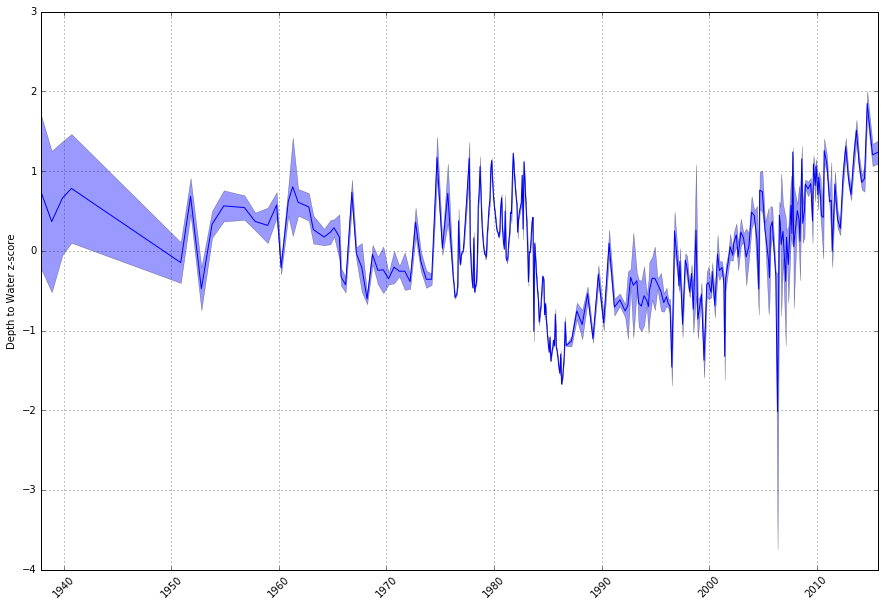

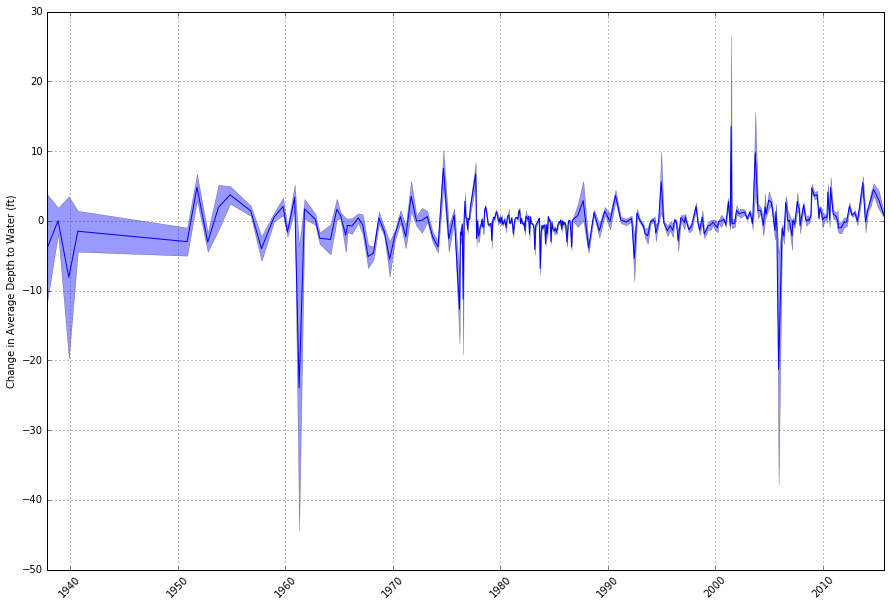

In [24]:
USGS.HUCplot(HUClist) #cedar city valley